# BigData | English Premier League Analysis

## Introducere

Acest proiect își propune să studieze și să analizeze campionatul de fotbal English Premier League (EPL) din Anglia, folosind un set de date ce acoperă meciuri disputate între anii 1993 și ianuarie 2025. Setul de date conține informații detaliate despre fiecare partidă, precum rezultatele finale și la pauză, numărul de goluri marcate, performanțele echipelor, date despre arbitri (inclusiv cartonașe galbene/roșii, faulturi, cornere etc.), dar și alte statistici relevante. Un aspect interesant al proiectului este faptul că sezonul 2024/2025 este în desfășurare (mid-season), ceea ce permite realizarea unor predicții privind clasamentul final pe baza datelor existente până în ianuarie 2025. Analiza va urmări atât performanța echipelor, cât și randamentul arbitrilor, încercând să identifice eventuale favorizări sau pattern-uri interesante, dar și alte idei ce pot reieși din explorarea datelor.

### a. Prezentarea succintă a setului de date

Setul de date utilizat conține, pentru fiecare meci din EPL, următoarele informații principale:

- Data și sezonul meciului
- Echipa gazdă și echipa oaspete
- Numărul de goluri marcate de fiecare echipă (final și la pauză)
- Rezultatul final și la pauză
- Numele arbitrului
- Statistici detaliate: șuturi, șuturi pe poartă, faulturi, cornere, cartonașe galbene și roșii, etc.
- Cote de pariuri și alte metadate

Exemplu de structură a datelor (coloane):

```
MatchID,Season,MatchWeek,Date,Time,HomeTeam,AwayTeam,FullTimeHomeTeamGoals,FullTimeAwayTeamGoals,FullTimeResult,HalfTimeHomeTeamGoals,HalfTimeAwayTeamGoals,HalfTimeResult,Referee,HomeTeamShots,AwayTeamShots,HomeTeamShotsOnTarget,AwayTeamShotsOnTarget,HomeTeamCorners,AwayTeamCorners,HomeTeamFouls,AwayTeamFouls,HomeTeamYellowCards,AwayTeamYellowCards,HomeTeamRedCards,AwayTeamRedCards,B365HomeTeam,B365Draw,B365AwayTeam,B365Over2.5Goals,B365Under2.5Goals,MarketMaxHomeTeam,MarketMaxDraw,MarketMaxAwayTeam,MarketAvgHomeTeam,MarketAvgDraw,MarketAvgAwayTeam,MarketMaxOver2.5Goals,MarketMaxUnder2.5Goals,MarketAvgOver2.5Goals,MarketAvgUnder2.5Goals,HomeTeamPoints,AwayTeamPoints
```

Datele provin din surse publice și pot fi accesate la următorul link: [Premier League Data](https://www.kaggle.com/datasets/ajaxianazarenka/premier-league?resource=download)

### b. Enunțarea obiectivelor

Obiectivele principale ale proiectului sunt:

1. Analiza performanței echipelor și a evoluției acestora de-a lungul sezoanelor EPL.
2. Studiul numărului de goluri marcate, identificarea tendințelor și a factorilor care influențează rezultatele.
3. Analiza randamentului arbitrilor: distribuția cartonașelor, faulturilor și identificarea eventualelor favorizări ale unor echipe de către anumiți arbitri.
4. Realizarea unor vizualizări relevante pentru a evidenția pattern-uri și corelații în date.
5. Deoarece sezonul 2024/2025 este în desfășurare (mid-season), se va încerca realizarea unei predicții a clasamentului final pe baza datelor existente până în ianuarie 2025.
6. Explorarea altor idei interesante care pot reieși din date, precum factori de influență asupra rezultatelor, performanța acasă vs. deplasare, etc.

Un alt scop principal al studiului este de a vedea si corelatia intre inceputul ciclului de victorii a echipei Manchester City si inceputul crizei a echipei Manchester United (ele fiind echipe din acelasi oras).

Proiectul va fi dezvoltat în notebook-ul `EPL_Analysis.ipynb`, folosind instrumente moderne de analiză a datelor și machine learning.


## 1. SPARK

### a. Inițializarea Spark și încărcarea datelor

În această etapă, inițializăm o sesiune Spark și încărcăm setul de date EPL într-un DataFrame Spark pentru a putea lucra cu volume mari de date.


In [16]:
from pyspark.sql import SparkSession

# Inițializăm sesiunea Spark
spark = SparkSession.builder.appName("EPL Analysis").getOrCreate()

# Încărcăm datele EPL într-un DataFrame Spark
df = spark.read.option("header", True).option(
    "inferSchema", True).csv("../data/PremierLeague_mid_season.csv")

# Afișăm primele 5 rânduri pentru a verifica încărcarea corectă a datelor
df.show(5)

+--------------------+---------+---------+----------+----+-----------+--------------+---------------------+---------------------+--------------+---------------------+---------------------+--------------+-------+-------------+-------------+---------------------+---------------------+---------------+---------------+-------------+-------------+-------------------+-------------------+----------------+----------------+------------+--------+------------+----------------+-----------------+-----------------+-------------+-----------------+-----------------+-------------+-----------------+---------------------+----------------------+---------------------+----------------------+--------------+--------------+
|             MatchID|   Season|MatchWeek|      Date|Time|   HomeTeam|      AwayTeam|FullTimeHomeTeamGoals|FullTimeAwayTeamGoals|FullTimeResult|HalfTimeHomeTeamGoals|HalfTimeAwayTeamGoals|HalfTimeResult|Referee|HomeTeamShots|AwayTeamShots|HomeTeamShotsOnTarget|AwayTeamShotsOnTarget|HomeTeamC

## b. Explorarea structurii și a valorilor lipsă

În această secțiune, vom analiza structura setului de date și vom identifica valorile lipsă. Acest lucru ne ajută să înțelegem calitatea datelor și să decidem ce preprocesări sunt necesare înainte de analiză. Vom afișa schema DataFrame-ului și vom calcula numărul de valori lipsă pentru fiecare coloană.


In [17]:
# Afișăm schema DataFrame-ului pentru a vedea tipurile de date și coloanele disponibile
from pyspark.sql.functions import col, sum as spark_sum
df.printSchema()

# Redenumim coloanele care conțin caractere speciale (ex: punctul) cu underscore
for col_name in df.columns:
    if '.' in col_name:
        df = df.withColumnRenamed(col_name, col_name.replace('.', '_'))

# Verificăm noile nume de coloane
print(df.columns)

# Calculăm numărul de valori lipsă (NULL) pentru fiecare coloană

missing_counts = df.select(
    [spark_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_counts.show()

root
 |-- MatchID: string (nullable = true)
 |-- Season: string (nullable = true)
 |-- MatchWeek: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- HomeTeam: string (nullable = true)
 |-- AwayTeam: string (nullable = true)
 |-- FullTimeHomeTeamGoals: integer (nullable = true)
 |-- FullTimeAwayTeamGoals: integer (nullable = true)
 |-- FullTimeResult: string (nullable = true)
 |-- HalfTimeHomeTeamGoals: integer (nullable = true)
 |-- HalfTimeAwayTeamGoals: integer (nullable = true)
 |-- HalfTimeResult: string (nullable = true)
 |-- Referee: string (nullable = true)
 |-- HomeTeamShots: integer (nullable = true)
 |-- AwayTeamShots: integer (nullable = true)
 |-- HomeTeamShotsOnTarget: integer (nullable = true)
 |-- AwayTeamShotsOnTarget: integer (nullable = true)
 |-- HomeTeamCorners: integer (nullable = true)
 |-- AwayTeamCorners: integer (nullable = true)
 |-- HomeTeamFouls: integer (nullable = true)
 |-- AwayTeamFouls: integer (nulla

## c. Separarea datelor pentru analize generale vs. analize detaliate

Pentru a asigura acuratețea analizelor, vom separa datele în două subseturi:

- Un subset pentru statistici generale (clasamente, goluri, puncte), unde folosim toate meciurile disponibile, chiar dacă unele coloane au valori lipsă.
- Un subset pentru analize detaliate (șuturi, cornere, arbitri etc.), unde păstrăm doar meciurile din sezonul 2000-2001 încolo și doar acele rânduri care au date complete pe coloanele relevante.


In [19]:
from pyspark.sql.functions import col

# Definim lista cu numele coloanelor de eliminat
cols_to_drop = [
    "Time",
    "B365HomeTeam", "B365Draw", "B365AwayTeam", "B365Over2_5Goals", "B365Under2_5Goals",
    "MarketMaxHomeTeam", "MarketMaxDraw", "MarketMaxAwayTeam",
    "MarketAvgHomeTeam", "MarketAvgDraw", "MarketAvgAwayTeam",
    "MarketMaxOver2_5Goals", "MarketMaxUnder2_5Goals",
    "MarketAvgOver2_5Goals", "MarketAvgUnder2_5Goals"
]

# Eliminăm coloanele doar dacă există în DataFrame
for col_name in cols_to_drop:
    if col_name in df.columns:
        df = df.drop(col_name)

general_cols = [
    "MatchID", "Season", "MatchWeek", "Date", "HomeTeam", "AwayTeam",
    "FullTimeHomeTeamGoals", "FullTimeAwayTeamGoals", "FullTimeResult",
    "HomeTeamPoints", "AwayTeamPoints"
]

# 1. Subset pentru statistici generale (toate meciurile cu scor și echipe)
df_general = df.select(general_cols).dropna()

# 2. Subset pentru analize detaliate (doar meciuri cu date complete, din 2000-2001 încolo)
relevant_cols = [
    "HomeTeam", "AwayTeam", "FullTimeHomeTeamGoals", "FullTimeAwayTeamGoals", "Date",
    "HalfTimeHomeTeamGoals", "HalfTimeAwayTeamGoals", "HalfTimeResult", "Referee",
    "HomeTeamShots", "AwayTeamShots", "HomeTeamShotsOnTarget", "AwayTeamShotsOnTarget",
    "HomeTeamCorners", "AwayTeamCorners", "HomeTeamFouls", "AwayTeamFouls",
    "HomeTeamYellowCards", "AwayTeamYellowCards", "HomeTeamRedCards", "AwayTeamRedCards"
]
df_detailed = (
    df
    .filter(col("Season") >= "2000-2001")
    .dropna(subset=relevant_cols)
)

# Verificăm câte meciuri avem în fiecare subset
print("Meciuri pentru statistici generale:", df_general.count())
print("Meciuri pentru analize detaliate:", df_detailed.count())
print("--------------------------------")

# Aratam primele 20 de rânduri din fiecare subset
df_general.show(20)
df_detailed.show(20)

Meciuri pentru statistici generale: 12001
Meciuri pentru analize detaliate: 9341
--------------------------------
+--------------------+---------+---------+----------+----------------+----------------+---------------------+---------------------+--------------+--------------+--------------+
|             MatchID|   Season|MatchWeek|      Date|        HomeTeam|        AwayTeam|FullTimeHomeTeamGoals|FullTimeAwayTeamGoals|FullTimeResult|HomeTeamPoints|AwayTeamPoints|
+--------------------+---------+---------+----------+----------------+----------------+---------------------+---------------------+--------------+--------------+--------------+
|1993-1994_Arsenal...|1993-1994|        1|1993-08-14|         Arsenal|        Coventry|                    0|                    3|             A|             0|             3|
|1993-1994_Aston V...|1993-1994|        1|1993-08-14|     Aston Villa|             QPR|                    4|                    1|             H|             3|             0|
|

## d. Playground cu datele

### I. Clasament general - Cele mai multe puncte all time din EPL, 1990-2025

În această secțiune, am realizat o analiză detaliată a performanței echipelor din English Premier League (EPL) pe baza datelor istorice disponibile, acoperind perioada 1990–2025. Analiza a fost efectuată utilizând Apache Spark, ceea ce a permis procesarea eficientă a unui volum mare de date și realizarea de agregări complexe.

- 1. Clasament pe fiecare sezon
     -- Pentru fiecare sezon din EPL, am calculat punctele obținute de fiecare echipă, atât în meciurile disputate pe teren propriu, cât și în deplasare. Punctajul total al fiecărei echipe într-un sezon a fost determinat prin însumarea punctelor obținute acasă și în deplasare. Ulterior, echipele au fost ordonate descrescător în funcție de punctajul total, obținând astfel clasamentul final pentru fiecare sezon. Pentru o vizualizare sintetică, am extras și afișat primele trei echipe din fiecare sezon, evidențiind astfel echipele de top ale fiecărui an competițional.

- 2. Determinarea câștigătoarei fiecărui sezon
     -- Pe baza clasamentului sezonier, am identificat câștigătoarea fiecărui sezon, adică echipa care a acumulat cele mai multe puncte la finalul sezonului respectiv. Acest demers permite o analiză longitudinală a performanței echipelor și evidențiază cluburile dominante de-a lungul istoriei EPL.

- 3. Clasamentul general all-time
     -- Am calculat și clasamentul general all-time, adunând punctele obținute de fiecare echipă în toate sezoanele analizate, atât acasă, cât și în deplasare. Acest clasament oferă o perspectivă globală asupra performanței echipelor pe termen lung, permițând identificarea celor mai de succes cluburi din istoria Premier League.

- 4. Numărul de campionate câștigate de fiecare echipă
     -- În final, am agregat numărul de titluri de campioană obținute de fiecare echipă, pe baza rezultatelor anuale. Acest indicator reflectă consistența și succesul echipelor de-a lungul timpului, oferind o imagine clară asupra palmaresului fiecărui club.

- 5. Numărul de meciuri jucate de fiecare echipă
     -- Am calculat numărul total de meciuri jucate de fiecare echipă în toate sezoanele analizate, atât acasă, cât și în deplasare. Acest indicator oferă o perspectivă asupra performanței echipelor pe termen lung, permițând identificarea celor mai consistente cluburi din istoria Premier League.


In [101]:
from pyspark.sql import Window
from pyspark.sql.functions import row_number, col, coalesce, lit, count, sum as spark_sum

# =========================
# 1. Clasament pe fiecare sezon
# =========================

print("\n=== Clasament pe fiecare sezon: Top 3 echipe/sezon ===")

# Calculăm punctele pe sezon pentru fiecare echipă (acasă + deplasare)
home_points_season = df_general.groupBy("Season", "HomeTeam").agg(
    spark_sum("HomeTeamPoints").alias("TotalHomePoints"))
away_points_season = df_general.groupBy("Season", "AwayTeam").agg(
    spark_sum("AwayTeamPoints").alias("TotalAwayPoints"))

# Redenumim pentru join
home_points_season = home_points_season.withColumnRenamed("HomeTeam", "Team")
away_points_season = away_points_season.withColumnRenamed("AwayTeam", "Team")

# Join și total
standings_season = home_points_season.join(
    away_points_season, on=["Season", "Team"], how="outer"
).withColumn(
    "TotalHomePoints", coalesce(home_points_season["TotalHomePoints"], lit(0))
).withColumn(
    "TotalAwayPoints", coalesce(away_points_season["TotalAwayPoints"], lit(0))
).withColumn(
    "TotalPoints", col("TotalHomePoints") + col("TotalAwayPoints")
)

# Pentru fiecare sezon, sortăm descrescător după puncte
window = Window.partitionBy("Season").orderBy(col("TotalPoints").desc())
standings_season = standings_season.withColumn(
    "Rank", row_number().over(window)
)

# Afișăm top 3 echipe din fiecare sezon
standings_season.filter(col("Rank") <= 3).orderBy(
    "Season", "Rank").show(20, truncate=False)

# =========================
# 2. Câștigătoarea fiecărui sezon
# =========================

print("\n=== Câștigătoarea fiecărui sezon ===")
winners = standings_season.filter(col("Rank") == 1).select(
    "Season", "Team", "TotalPoints")
winners.show(truncate=False)

# =========================
# 3. Clasamentul general all-time (toate punctele adunate)
# =========================

print("\n=== Clasament general all-time (toate punctele adunate) ===")
home_points = df_general.groupBy("HomeTeam").agg(
    spark_sum("HomeTeamPoints").alias("TotalHomePoints"))
away_points = df_general.groupBy("AwayTeam").agg(
    spark_sum("AwayTeamPoints").alias("TotalAwayPoints"))

home_points = home_points.withColumnRenamed("HomeTeam", "Team")
away_points = away_points.withColumnRenamed("AwayTeam", "Team")

standings_alltime = home_points.join(away_points, on="Team", how="outer") \
    .withColumn("TotalHomePoints", coalesce(home_points["TotalHomePoints"], lit(0))) \
    .withColumn("TotalAwayPoints", coalesce(away_points["TotalAwayPoints"], lit(0))) \
    .withColumn("TotalPoints", col("TotalHomePoints") + col("TotalAwayPoints"))

standings_alltime = standings_alltime.orderBy(col("TotalPoints").desc())
standings_alltime.show(20, truncate=False)

# =========================
# 4. Număr campionate câștigate de fiecare echipă
# =========================

print("\n=== Număr campionate câștigate de fiecare echipă ===")
winners_counter = winners.groupBy("Team").agg(count("Season").alias(
    "Championships")).orderBy(col("Championships").desc())
winners_counter.show(truncate=False)

# =========================
# 5. Numar total de meciuri jucate de fiecare echipa
# =========================

print("\n=== Număr total de meciuri jucate de fiecare echipă ===")

# Numărăm numărul total de meciuri jucate de fiecare echipă ordonat descrescator dupa numarul de meciuri
total_matches_per_team = df_general.groupBy("HomeTeam").agg(
    count("HomeTeam").alias("TotalMatches")
).withColumnRenamed("HomeTeam", "Team").orderBy(col("TotalMatches").desc())

# Afișăm rezultatele
total_matches_per_team.show(100, truncate=False)


=== Clasament pe fiecare sezon: Top 3 echipe/sezon ===
+---------+----------+---------------+---------------+-----------+----+
|Season   |Team      |TotalHomePoints|TotalAwayPoints|TotalPoints|Rank|
+---------+----------+---------------+---------------+-----------+----+
|1993-1994|Man United|38             |38             |76         |1   |
|1993-1994|Blackburn |42             |31             |73         |2   |
|1993-1994|Newcastle |36             |28             |64         |3   |
|1994-1995|Blackburn |47             |32             |79         |1   |
|1994-1995|Man United|45             |29             |74         |2   |
|1994-1995|Newcastle |41             |23             |64         |3   |
|1995-1996|Man United|49             |33             |82         |1   |
|1995-1996|Newcastle |52             |26             |78         |2   |
|1995-1996|Liverpool |46             |25             |71         |3   |
|1996-1997|Man United|41             |34             |75         |1   |
|1996-19

Voi crea acum niste vizualizari pentru a vedea cum se comporta echipele in timp.

#### 1. Bar chart: Top 10 echipe all-time după puncte

Vizualizarea de mai jos prezintă, sub formă de bar chart, primele 10 echipe din istoria Premier League în funcție de totalul punctelor acumulate all-time. Graficul evidențiază cluburile cu cele mai bune performanțe pe termen lung, oferind o perspectivă rapidă asupra echipelor dominante din EPL.

Putem observa ca echipa de pe locul 1 este Manchester United, care a castigat si 12 titluri de campioana. Am putea spune ca este si "normal" ca Manchester United sa fie pe primul loc, deoarece a fost una dintre cele mai "bune" echipe din EPL in ultimii 30 de ani; Am putea studia echipa asta si Manchester City, oarecum inceperea dominiului Manchester City este concomitenta cu inceperea caderii Manchester United.


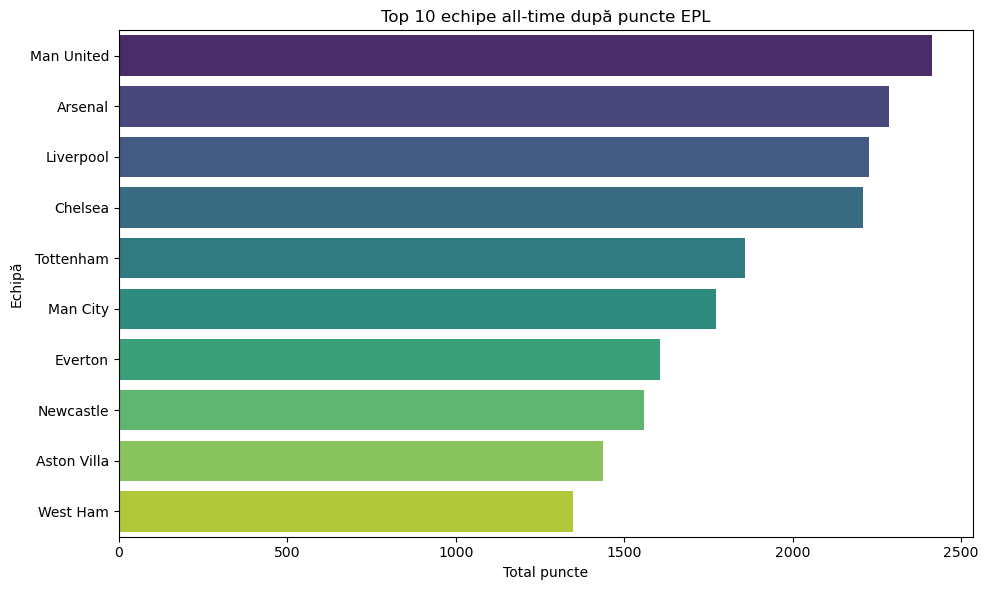

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convertim standings_alltime în Pandas pentru vizualizare
top10_alltime = standings_alltime.limit(10).toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=top10_alltime, x="TotalPoints", y="Team",
            hue="Team", palette="viridis", dodge=False, legend=False)
plt.title("Top 10 echipe all-time după puncte EPL")
plt.xlabel("Total puncte")
plt.ylabel("Echipă")
plt.tight_layout()
plt.show()

#### 2. Bar chart: Top echipe după numărul de campionate câștigate

Graficul de mai jos ilustrează numărul de campionate câștigate de fiecare echipă în Premier League. Această vizualizare evidențiază cluburile cu cele mai multe titluri de campioană, oferind o imagine clară asupra palmaresului echipelor de top din EPL.

Aici putem observa distributia echipelor care au castigat titlul de campioana in ultimii 30 de ani.
Am facut si o vizualizare a echipelor care au castigat titlul de campioana in ultimii 30 de ani, si pentru studiul nostru despre comparatia intre Manchester United si Manchester City, am facut o vizualizare a echipelor care au castigat titlul de campioana pana in sezonul 2007-2008 si o alta vizualizare care ia in calcul datele din sezonul 2008-2009 si am observat ca se vede clar o cumpana intre cele 2 echipe. Din anul 2008-2009, Manchester City a inceput sa castige titluri de campioana, cand Manchester United a inceput sa fie mai deficitara cu rezultatele.


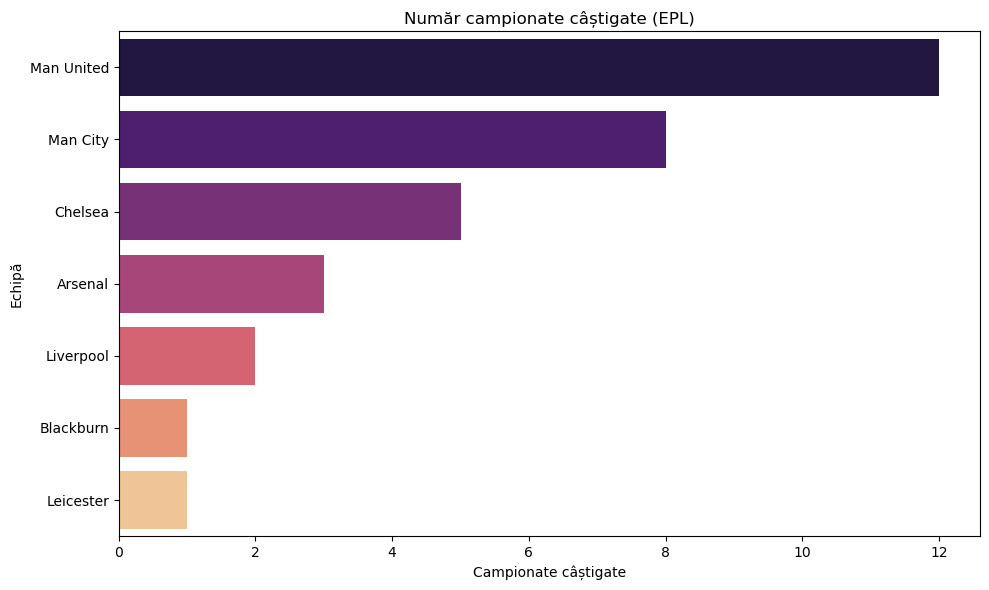

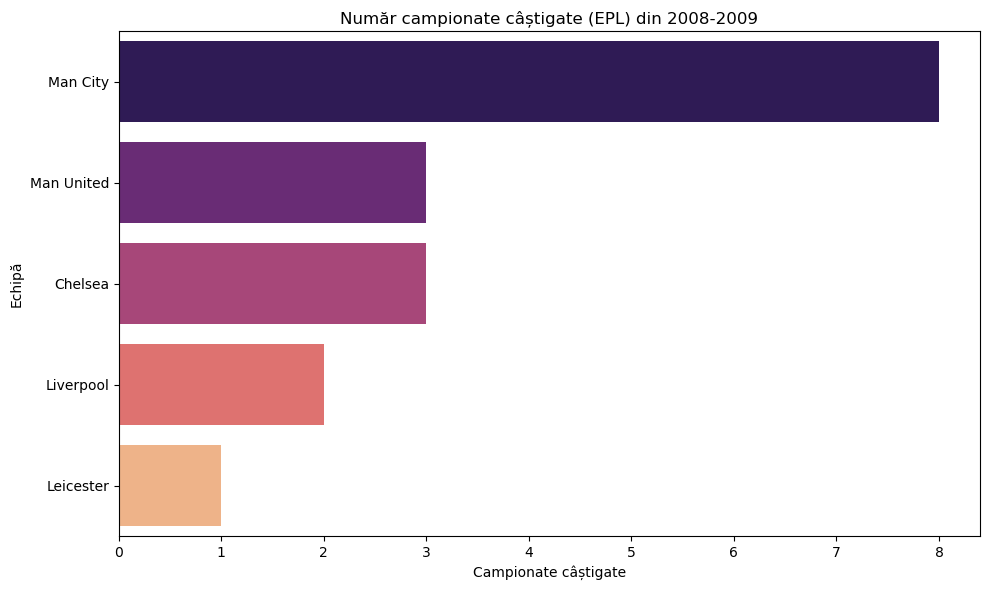

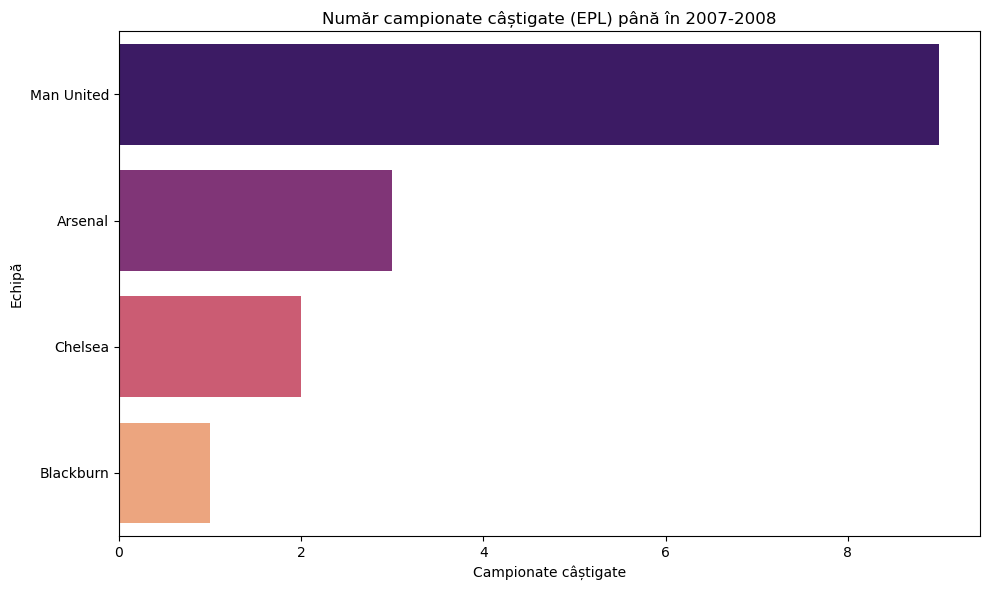

In [97]:
# Convertim winners_counter în Pandas
winners_counter_pd = winners_counter.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=winners_counter_pd, x="Championships", y="Team",
            palette="magma", hue="Team", dodge=False, legend=False)
plt.title("Număr campionate câștigate (EPL)")
plt.xlabel("Campionate câștigate")
plt.ylabel("Echipă")
plt.tight_layout()
plt.show()

# Filtrăm câștigătorii din 2008-2009 inclusiv și după
winners_2008plus = winners.filter(col("Season") >= "2008-2009")

# Numărăm câte campionate a câștigat fiecare echipă în această perioadă
winners_counter_2008plus = winners_2008plus.groupBy("Team").agg(
    count("Season").alias("Championships")
).orderBy(col("Championships").desc())

# Convertim în Pandas și plot
winners_counter_2008plus_pd = winners_counter_2008plus.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=winners_counter_2008plus_pd, x="Championships", y="Team",
            palette="magma", hue="Team", dodge=False, legend=False)
plt.title("Număr campionate câștigate (EPL) din 2008-2009")
plt.xlabel("Campionate câștigate")
plt.ylabel("Echipă")
plt.tight_layout()
plt.show()

# Filtrăm câștigătorii până în 2007-2008 inclusiv
winners_pre2008 = winners.filter(col("Season") <= "2007-2008")

# Numărăm câte campionate a câștigat fiecare echipă în această perioadă
winners_counter_pre2008 = winners_pre2008.groupBy("Team").agg(
    count("Season").alias("Championships")
).orderBy(col("Championships").desc())

# Convertim în Pandas și plot
winners_counter_pre2008_pd = winners_counter_pre2008.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=winners_counter_pre2008_pd, x="Championships", y="Team",
            palette="magma", hue="Team", dodge=False, legend=False)
plt.title("Număr campionate câștigate (EPL) până în 2007-2008")
plt.xlabel("Campionate câștigate")
plt.ylabel("Echipă")
plt.tight_layout()
plt.show()

#### 3. Line plot: Evoluția punctelor si clasamentului pentru o echipă de top pe sezoane

Graficele următoare ilustrează evoluția echipelor Manchester United si Manchester City în Premier League de-a lungul sezoanelor analizate. Primul grafic prezintă totalul punctelor obținute al echipelor în fiecare sezon, evidențiind performanța lor de la an la an. Al doilea grafic arată poziția ocupată în clasament la finalul fiecărui sezon, oferind o perspectivă clară asupra constanței și progresului echipelor în EPL.

Se poate observa cum pentru echipa Manchester United, pana in sezonul 2012-2013, echipa a fost una dintre cele mai bune echipe din EPL, luptand in fiecare an pentru titlul de campioana; Din sezonul urmator a inceput o perioada de cadere, in care echipa nu a reusit sa castige titlul de campioana, si nici sa se califice in competitia europeana Champions League in mai multe ocazii (fiind calificarea intre primele 4 locuri).

Iar pentru Manchester City, se poate observa ca din sezonul 2009-2010 echipa a inceput sa castige mai multe puncte (multumita si faptului ca a fost achizitionata de catre Abu Dhabi United Group in Septembrie 2008 si a inceput sa investeasca in echipa); din momentul acela echipa a castigat 8 titluri de campioana (primul find acela din sezonul 2011-2012); Se mai poate observa ca de atunci a fost aproape un monopol al echipei, care din sezonul 2017-2018 a castigat 6 titluri in 7 ani (lant rupt de Liverpool in 2019-2020).


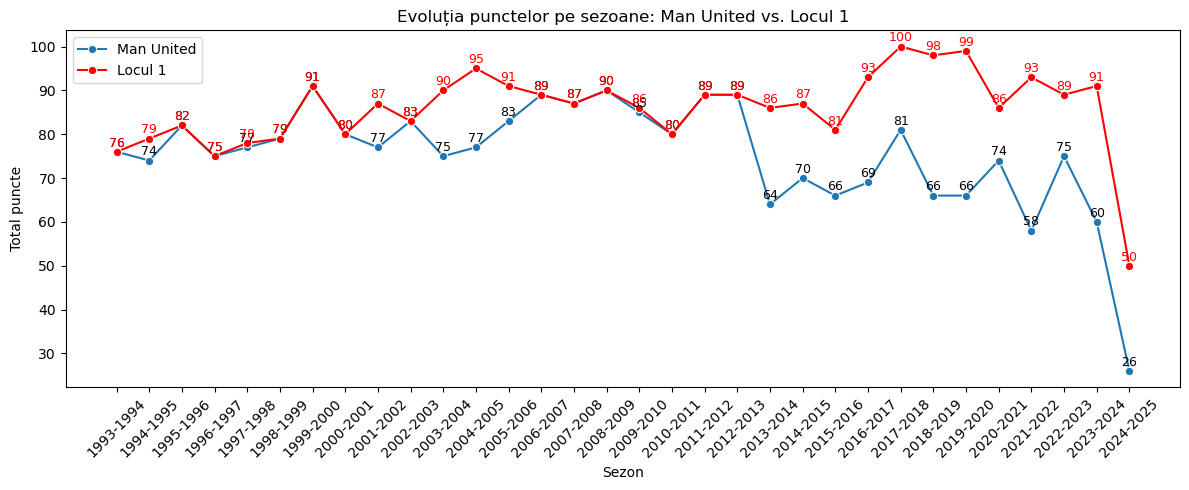

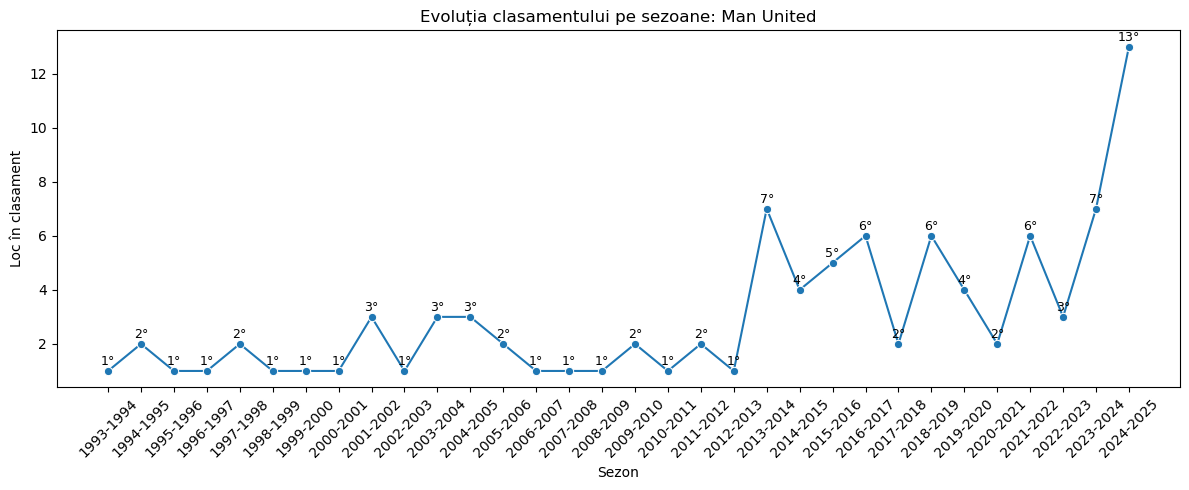

In [94]:
team_name = "Man United"
team_history = standings_season.filter(
    col("Team") == team_name).orderBy("Season").toPandas()

# Obținem punctele echipei de pe primul loc pentru fiecare sezon
first_place = standings_season.filter(
    col("Rank") == 1).orderBy("Season").toPandas()
first_place = first_place[["Season", "TotalPoints"]].rename(
    columns={"TotalPoints": "FirstPlacePoints"})

# Facem merge pentru a avea și punctele primului loc în același DataFrame
team_history = team_history.merge(first_place, on="Season", how="left")

plt.figure(figsize=(12, 5))
sns.lineplot(data=team_history, x="Season",
             y="TotalPoints", marker="o", label=team_name)
sns.lineplot(data=team_history, x="Season", y="FirstPlacePoints",
             marker="o", color="red", label="Locul 1")
plt.title(f"Evoluția punctelor pe sezoane: {team_name} vs. Locul 1")
plt.xlabel("Sezon")
plt.ylabel("Total puncte")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

for i, row in team_history.iterrows():
    plt.text(row["Season"], row["TotalPoints"] + 0.5, str(int(row["TotalPoints"])),
             ha='center', va='bottom', fontsize=9, color='black')
    plt.text(row["Season"], row["FirstPlacePoints"] + 0.5, str(int(row["FirstPlacePoints"])),
             ha='center', va='bottom', fontsize=9, color='red')

plt.show()

plt.figure(figsize=(12, 5))
sns.lineplot(data=team_history, x="Season", y="Rank", marker="o")
plt.title(f"Evoluția clasamentului pe sezoane: {team_name}")
plt.xlabel("Sezon")
plt.ylabel("Loc în clasament")
plt.xticks(rotation=45)
plt.tight_layout()

# Adaugă valoarea la fiecare punct
for i, row in team_history.iterrows():
    plt.text(row["Season"], row["Rank"] + 0.1, str(int(row["Rank"])) + "°",
             ha='center', va='bottom', fontsize=9, color='black')

plt.show()

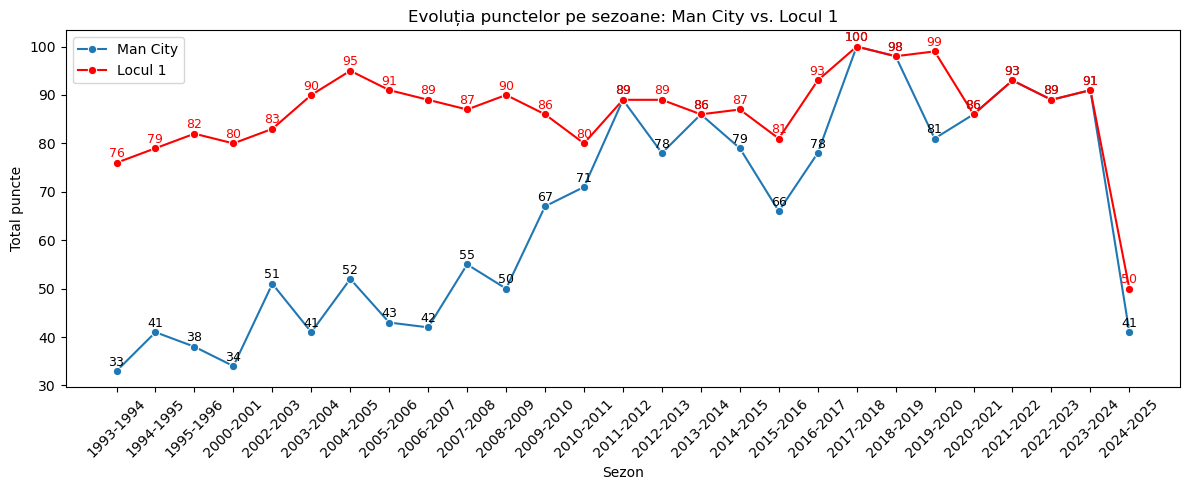

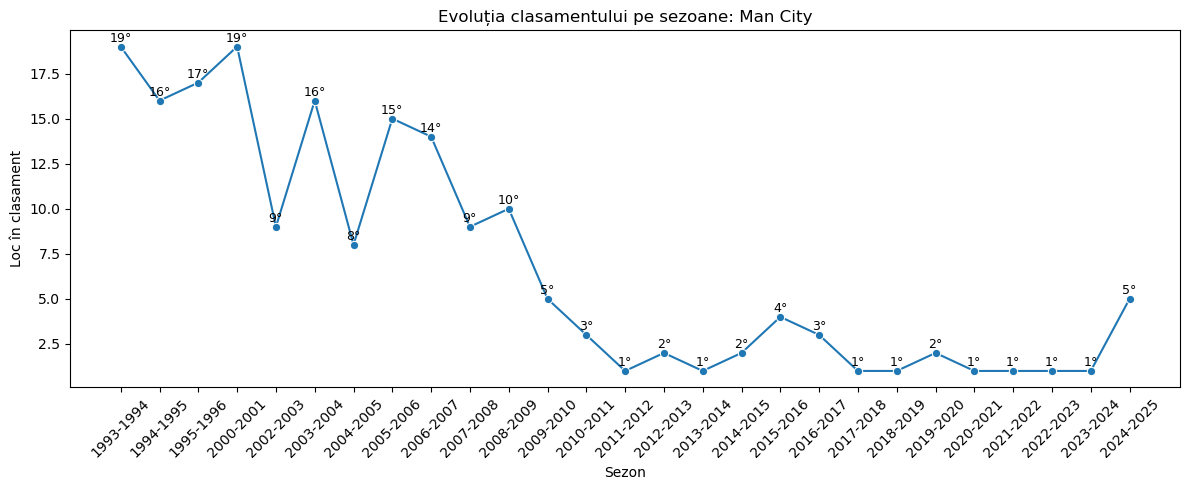

In [93]:
team_name = "Man City"
team_history = standings_season.filter(
    col("Team") == team_name).orderBy("Season").toPandas()

# Obținem punctele echipei de pe primul loc pentru fiecare sezon
first_place = standings_season.filter(
    col("Rank") == 1).orderBy("Season").toPandas()
first_place = first_place[["Season", "TotalPoints"]].rename(
    columns={"TotalPoints": "FirstPlacePoints"})

# Facem merge pentru a avea și punctele primului loc în același DataFrame
team_history = team_history.merge(first_place, on="Season", how="left")

plt.figure(figsize=(12, 5))
sns.lineplot(data=team_history, x="Season",
             y="TotalPoints", marker="o", label=team_name)
sns.lineplot(data=team_history, x="Season", y="FirstPlacePoints",
             marker="o", color="red", label="Locul 1")
plt.title(f"Evoluția punctelor pe sezoane: {team_name} vs. Locul 1")
plt.xlabel("Sezon")
plt.ylabel("Total puncte")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

for i, row in team_history.iterrows():
    plt.text(row["Season"], row["TotalPoints"] + 0.5, str(int(row["TotalPoints"])),
             ha='center', va='bottom', fontsize=9, color='black')
    plt.text(row["Season"], row["FirstPlacePoints"] + 0.5, str(int(row["FirstPlacePoints"])),
             ha='center', va='bottom', fontsize=9, color='red')

plt.show()

plt.figure(figsize=(12, 5))
sns.lineplot(data=team_history, x="Season", y="Rank", marker="o")
plt.title(f"Evoluția clasamentului pe sezoane: {team_name}")
plt.xlabel("Sezon")
plt.ylabel("Loc în clasament")
plt.xticks(rotation=45)
plt.tight_layout()

# Adaugă valoarea la fiecare punct
for i, row in team_history.iterrows():
    plt.text(row["Season"], row["Rank"] + 0.1, str(int(row["Rank"])) + "°",
             ha='center', va='bottom', fontsize=9, color='black')

plt.show()

#### 4. Heatmap: Pozițiile echipelor de top pe sezoane

In aceasta sectiune vom analiza cum au evoluat echipele in timp, si cum au evoluat si clasamentul lor.

Putem observa spre exemplu echipa Leicester City, care a castigat titlul de campioana in sezonul 2015-2016, echipa care la inceputul sezonului 2015-2016 era considerata ca o echipa care avea sanse de a retrogada in Liga 2 -> Chmapionship.
Alt exemplu sunt echipele Liverpool, Arsenal si Manchester United care pot fi considerate cele "4 surori" al campionatului deoarece toate au fost în mod regulat în topul clasamentului pe termen lung (nu doar un boom de cativa ani, cum a fost la Manchester City sau Tottenham mai recent).


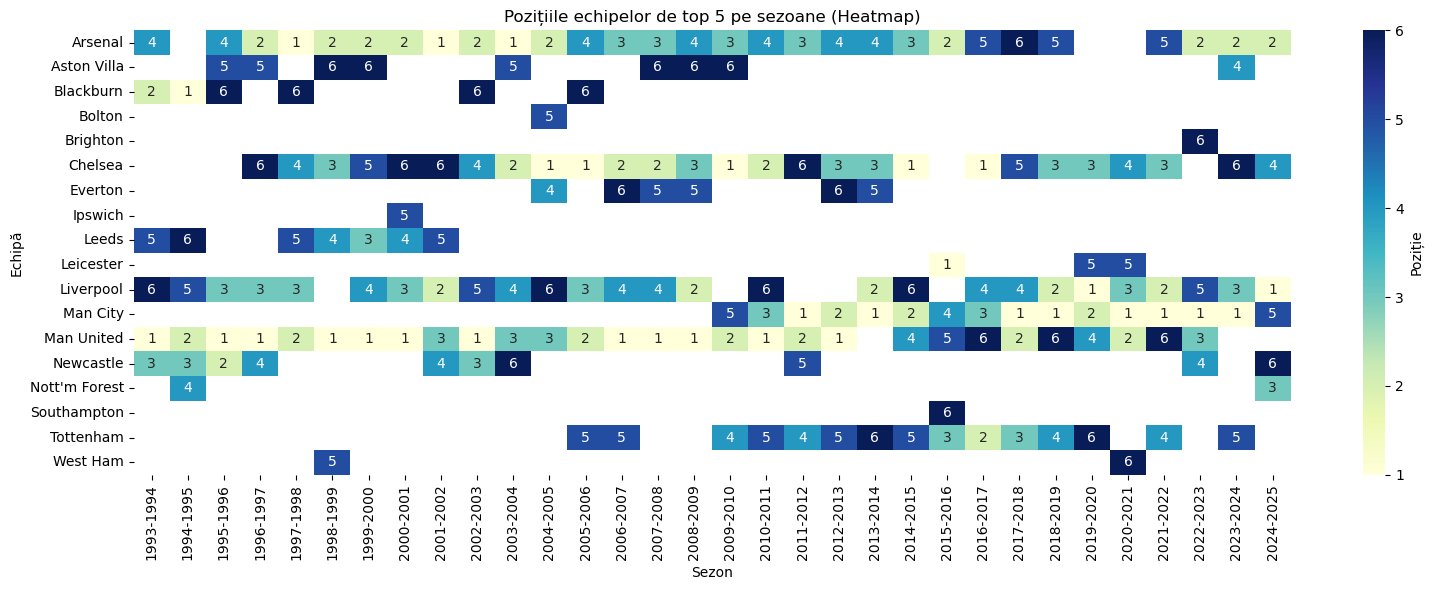

In [ ]:
bump_data = standings_season.filter(
    col("Rank") <= 5).orderBy("Season", "Team").toPandas()

# Pregătim un pivot pentru heatmap
heatmap_data = bump_data.pivot(index="Team", columns="Season", values="Rank")

plt.figure(figsize=(16, 6))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu",
            cbar_kws={'label': 'Poziție'})
plt.title("Pozițiile echipelor de top 5 pe sezoane (Heatmap)")
plt.xlabel("Sezon")
plt.ylabel("Echipă")
plt.tight_layout()
plt.show()

### II. Distribuția rezultatelor (victorii, egaluri, înfrângeri) pentru fiecare echipă

Vom calcula pentru fiecare echipă câte victorii, egaluri și înfrângeri a avut de-a lungul timpului, atât acasă cât și în deplasare.


In [50]:
from pyspark.sql.functions import when

# Victorii acasă
home_wins = df_general.groupBy("HomeTeam").agg(
    (spark_sum(when(col("FullTimeResult") == "H", 1).otherwise(0))).alias("HomeWins"),
    (spark_sum(when(col("FullTimeResult") == "D", 1).otherwise(0))).alias("HomeDraws"),
    (spark_sum(when(col("FullTimeResult") == "A", 1).otherwise(0))).alias("HomeLosses")
).withColumnRenamed("HomeTeam", "Team")

# Victorii în deplasare
away_wins = df_general.groupBy("AwayTeam").agg(
    (spark_sum(when(col("FullTimeResult") == "A", 1).otherwise(0))).alias("AwayWins"),
    (spark_sum(when(col("FullTimeResult") == "D", 1).otherwise(0))).alias("AwayDraws"),
    (spark_sum(when(col("FullTimeResult") == "H", 1).otherwise(0))).alias("AwayLosses")
).withColumnRenamed("AwayTeam", "Team")

# Join și totaluri
results = home_wins.join(away_wins, on="Team", how="outer") \
    .withColumn("TotalWins", coalesce(col("HomeWins"), lit(0)) + coalesce(col("AwayWins"), lit(0))) \
    .withColumn("TotalDraws", coalesce(col("HomeDraws"), lit(0)) + coalesce(col("AwayDraws"), lit(0))) \
    .withColumn("TotalLosses", coalesce(col("HomeLosses"), lit(0)) + coalesce(col("AwayLosses"), lit(0)))

results = results.orderBy(col("TotalWins").desc())
results.show(10, truncate=False)

+-----------+--------+---------+----------+--------+---------+----------+---------+----------+-----------+
|Team       |HomeWins|HomeDraws|HomeLosses|AwayWins|AwayDraws|AwayLosses|TotalWins|TotalDraws|TotalLosses|
+-----------+--------+---------+----------+--------+---------+----------+---------+----------+-----------+
|Man United |413     |110      |75        |305     |149      |143       |718      |259       |218        |
|Arsenal    |394     |131      |72        |272     |156      |169       |666      |287       |241        |
|Liverpool  |381     |143      |71        |263     |151      |181       |644      |294       |252        |
|Chelsea    |363     |150      |84        |277     |139      |180       |640      |289       |264        |
|Tottenham  |326     |129      |142       |200     |152      |243       |526      |281       |385        |
|Man City   |308     |94       |100       |213     |116      |174       |521      |210       |274        |
|Everton    |275     |155      |167  

#### 1. Stacked Bar Chart pentru Top 10 echipe (victorii, egaluri, înfrângeri)

In graficul acesta putem observa ca din totate echipele care au jucat in Premier League, doar 5 au un randament super pozitiv unde au castigat mai multe meciuri decat au pierdut si egalat; In cazul in care luam in calcul victorii + egaluri, putem observa ca 9 echipe au un randament pozitiv;


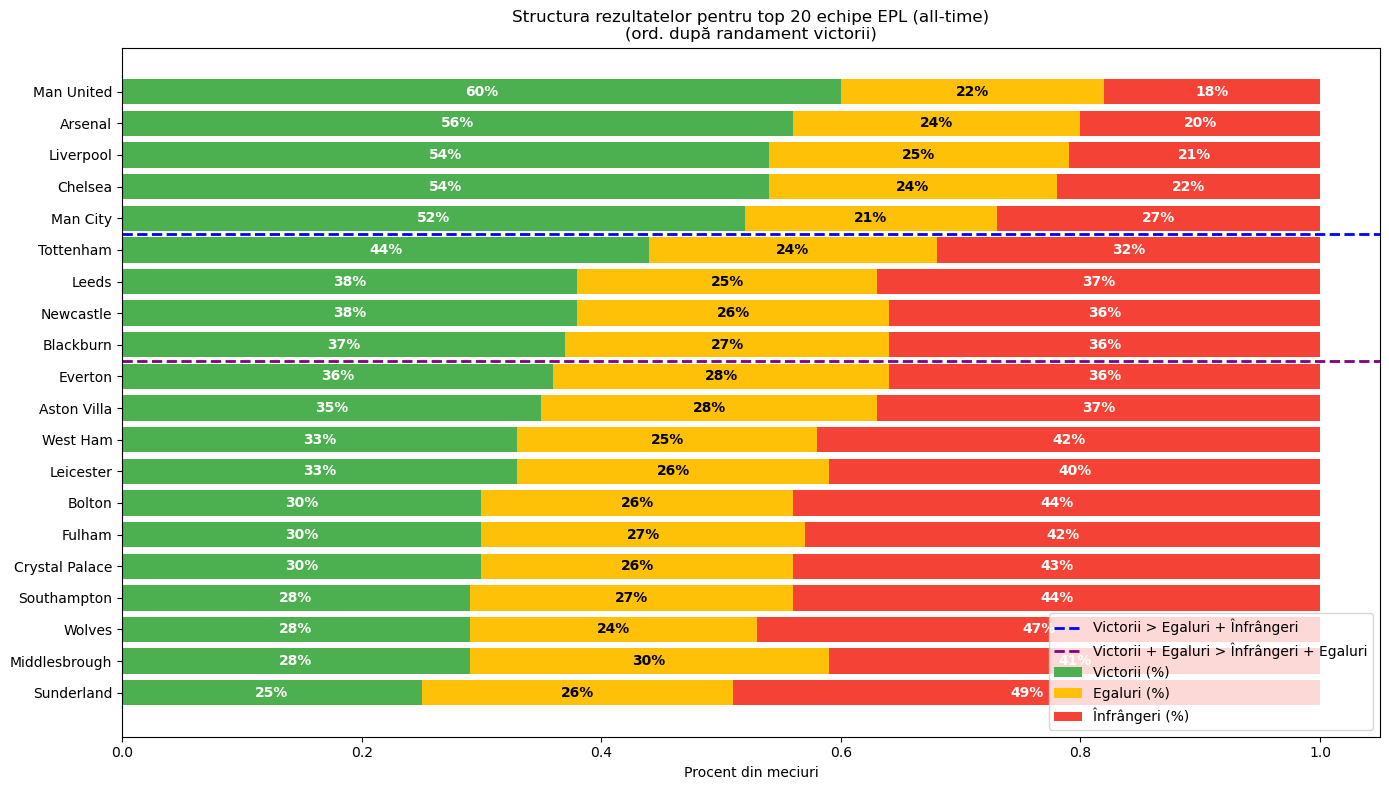

In [118]:
import matplotlib.pyplot as plt
import numpy as np

# Convertim rezultatele în Pandas și selectăm top 20 echipe după victorii
top20_results = results.orderBy(col("TotalWins").desc()).limit(20).toPandas()

# Calculăm total meciuri și randamentul
top20_results["TotalMatches"] = top20_results["TotalWins"] + \
    top20_results["TotalDraws"] + top20_results["TotalLosses"]
top20_results["WinRatio"] = top20_results["TotalWins"] / \
    top20_results["TotalMatches"]

# Ordonăm descrescător după randament
top20_results = top20_results.sort_values(
    by="WinRatio", ascending=False).reset_index(drop=True)

teams = top20_results["Team"]
wins = top20_results["TotalWins"]
draws = top20_results["TotalDraws"]
losses = top20_results["TotalLosses"]
total_matches = top20_results["TotalMatches"]

wins_pct = (wins / total_matches).round(2)
draws_pct = (draws / total_matches).round(2)
losses_pct = (losses / total_matches).round(2)

# Ajustăm ultima categorie pentru a evita depășirea 100%
for i in range(len(teams)):
    s = wins_pct.iloc[i] + draws_pct.iloc[i] + losses_pct.iloc[i]
    if s != 1.0:
        losses_pct.iloc[i] = 1.0 - wins_pct.iloc[i] - draws_pct.iloc[i]

# Calculăm pozițiile pentru linii separatorii
# 1. Unde victorii > egaluri + înfrângeri
sep1 = np.where(wins.values > (draws.values + losses.values))[0]
sep1_pos = sep1[-1] + 0.5 if len(sep1) > 0 else None

# 2. Unde victorii + egaluri > înfrângeri + egaluri (adică victorii > înfrângeri)
sep2 = np.where((wins.values + draws.values) >
                (losses.values + draws.values))[0]
sep2_pos = sep2[-1] + 0.5 if len(sep2) > 0 else None

plt.figure(figsize=(14, 8))
plt.barh(teams, wins_pct, color="#4CAF50", label="Victorii (%)")
plt.barh(teams, draws_pct, left=wins_pct, color="#FFC107", label="Egaluri (%)")
plt.barh(teams, losses_pct, left=wins_pct+draws_pct,
         color="#F44336", label="Înfrângeri (%)")

plt.xlabel("Procent din meciuri")
plt.title("Structura rezultatelor pentru top 20 echipe EPL (all-time)\n(ord. după randament victorii)")
plt.legend(loc="lower right")
plt.gca().invert_yaxis()
plt.tight_layout()

# Adăugăm procentul în fiecare dreptunghi
for i, team in enumerate(teams):
    if wins_pct.iloc[i] > 0.03:
        plt.text(wins_pct.iloc[i]/2, i, f"{int(wins_pct.iloc[i]*100)}%",
                 va='center', ha='center', color='white', fontweight='bold')
    if draws_pct.iloc[i] > 0.03:
        plt.text(wins_pct.iloc[i] + draws_pct.iloc[i]/2, i,
                 f"{int(draws_pct.iloc[i]*100)}%", va='center', ha='center', color='black', fontweight='bold')
    if losses_pct.iloc[i] > 0.03:
        plt.text(wins_pct.iloc[i] + draws_pct.iloc[i] + losses_pct.iloc[i]/2, i,
                 f"{int(losses_pct.iloc[i]*100)}%", va='center', ha='center', color='white', fontweight='bold')

# Adăugăm liniile separatorii
if sep1_pos is not None:
    plt.axhline(sep1_pos, color='blue', linestyle='--',
                linewidth=2, label="Victorii > Egaluri + Înfrângeri")
if sep2_pos is not None:
    plt.axhline(sep2_pos, color='purple', linestyle='--', linewidth=2,
                label="Victorii + Egaluri > Înfrângeri + Egaluri")

# Adăugăm legendă pentru linii
handles, labels = plt.gca().get_legend_handles_labels()
if sep1_pos is not None or sep2_pos is not None:
    plt.legend(handles, labels, loc="lower right")

plt.show()

#### 2. Heatmap Victorii Acasă vs. Deplasare pentru fiecare echipă

Din Vizualizarea de mai sus putem observa ca echipele de obicei castiga mai multe meciuri acasa decat in deplasare, unicele echipe care au Acasa = Deplasare sunt Blackpool si Oldham cu 5 si respectiv 4 meciuri castigate in ambele situatii.


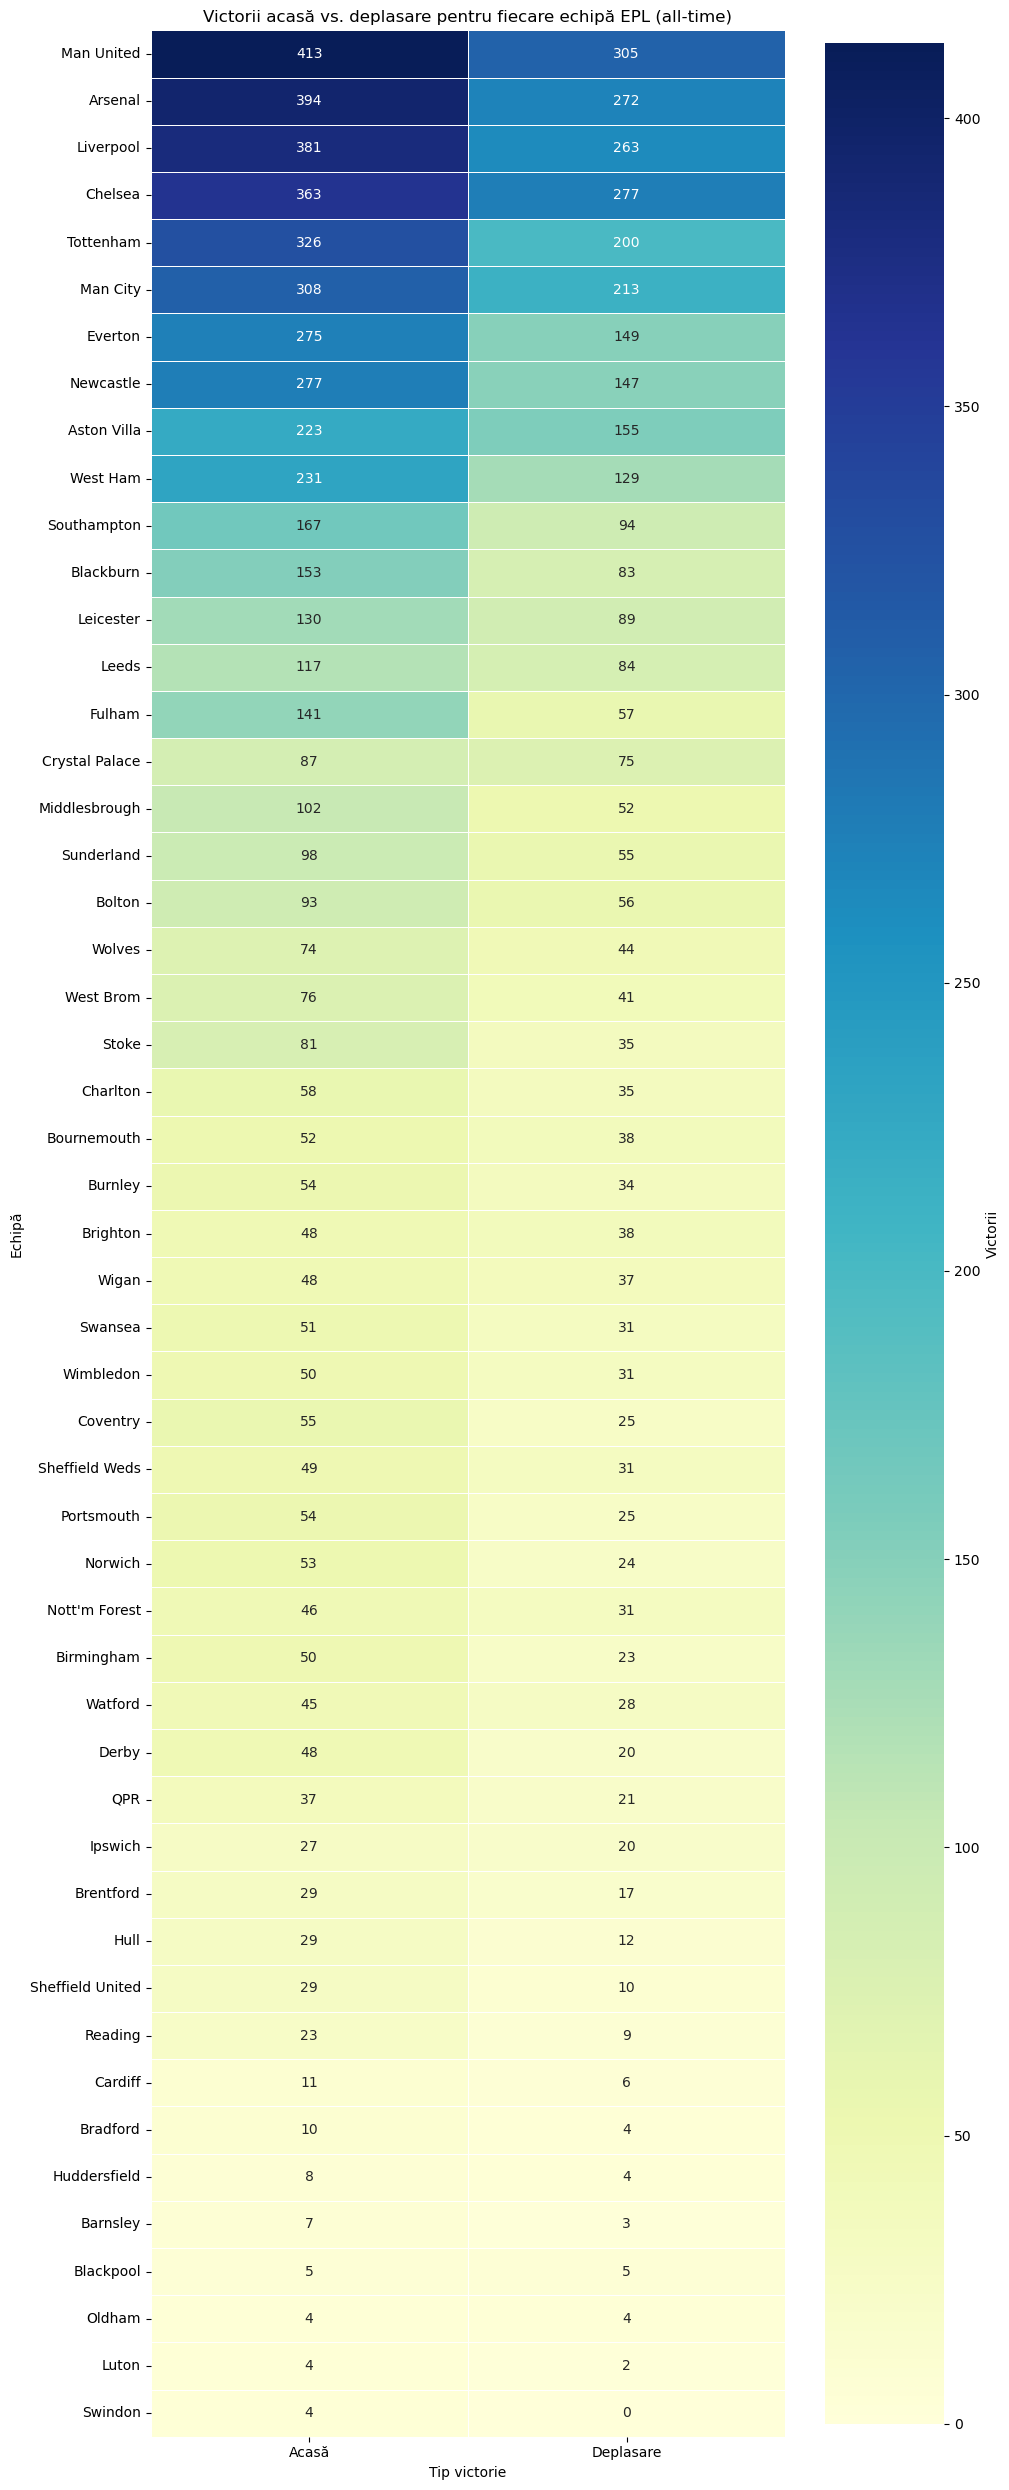

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Selectăm doar coloanele relevante și convertim în Pandas
victories = results.select("Team", "HomeWins", "AwayWins").toPandas()

# Facem un melt pentru a avea o coloană 'Type' (Home/Away) și una cu valorile
victories_melted = victories.melt(id_vars="Team", value_vars=["HomeWins", "AwayWins"],
                                  var_name="Type", value_name="Wins")
victories_melted["Type"] = victories_melted["Type"].replace(
    {"HomeWins": "Acasă", "AwayWins": "Deplasare"})

# Pentru claritate, sortăm echipele după total victorii
victories["TotalWins"] = victories["HomeWins"] + victories["AwayWins"]
top_teams = victories.sort_values("TotalWins", ascending=False)[
    "Team"].tolist()

plt.figure(figsize=(10, max(6, len(top_teams)//2)))
heatmap_data = victories_melted.pivot(
    index="Team", columns="Type", values="Wins").loc[top_teams]

sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu",
            linewidths=0.5, cbar_kws={'label': 'Victorii'})
plt.title("Victorii acasă vs. deplasare pentru fiecare echipă EPL (all-time)")
plt.xlabel("Tip victorie")
plt.ylabel("Echipă")
plt.tight_layout()
plt.show()

### III. Total goluri marcate și primite de fiecare echipă

Vom calcula câte goluri a marcat și a primit fiecare echipă, atât acasă cât și în deplasare, și totalul pe toată perioada.


In [54]:
# Goluri marcate acasă și primite acasă
home_goals = df_general.groupBy("HomeTeam").agg(
    spark_sum("FullTimeHomeTeamGoals").alias("GoalsScoredHome"),
    spark_sum("FullTimeAwayTeamGoals").alias("GoalsConcededHome")
).withColumnRenamed("HomeTeam", "Team")

# Goluri marcate în deplasare și primite în deplasare
away_goals = df_general.groupBy("AwayTeam").agg(
    spark_sum("FullTimeAwayTeamGoals").alias("GoalsScoredAway"),
    spark_sum("FullTimeHomeTeamGoals").alias("GoalsConcededAway")
).withColumnRenamed("AwayTeam", "Team")

# Join și totaluri
goals = home_goals.join(away_goals, on="Team", how="outer") \
    .withColumn("TotalGoalsScored", coalesce(col("GoalsScoredHome"), lit(0)) + coalesce(col("GoalsScoredAway"), lit(0))) \
    .withColumn("TotalGoalsConceded", coalesce(col("GoalsConcededHome"), lit(0)) + coalesce(col("GoalsConcededAway"), lit(0)))

goals = goals.orderBy(col("TotalGoalsScored").desc())
goals.show(10, truncate=False)

+-----------+---------------+-----------------+---------------+-----------------+----------------+------------------+
|Team       |GoalsScoredHome|GoalsConcededHome|GoalsScoredAway|GoalsConcededAway|TotalGoalsScored|TotalGoalsConceded|
+-----------+---------------+-----------------+---------------+-----------------+----------------+------------------+
|Man United |1249           |469              |989            |691              |2238            |1160              |
|Arsenal    |1245           |513              |937            |674              |2182            |1187              |
|Liverpool  |1221           |474              |932            |706              |2153            |1180              |
|Chelsea    |1166           |514              |897            |677              |2063            |1191              |
|Tottenham  |1046           |655              |807            |852              |1853            |1507              |
|Man City   |1049           |472              |770      

#### 1. HeatMap: Goluri Marcate vs. Primite (Top 10 echipe)

Din mapa aceasta se poate observa ca echipele cele mai multe goluri Acasa si primeste mai multe goluri in deplasare; Caz curios este echipa Aston Villa care are 615 goluri marcate in deplasare si 615 goluri primite acasa.


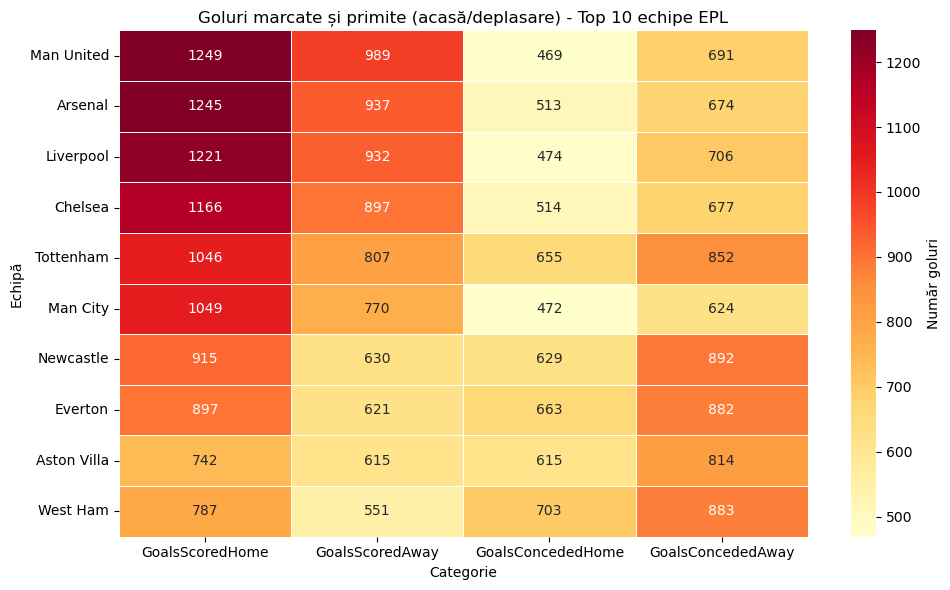

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Selectăm top 10 echipe după goluri marcate
top10_teams = goals.orderBy(
    col("TotalGoalsScored").desc()).limit(10).toPandas()

# Pregătim un DataFrame pentru heatmap
heatmap_data = top10_teams.set_index("Team")[
    ["GoalsScoredHome", "GoalsScoredAway", "GoalsConcededHome", "GoalsConcededAway"]]

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlOrRd",
            linewidths=0.5, cbar_kws={'label': 'Număr goluri'})
plt.title("Goluri marcate și primite (acasă/deplasare) - Top 10 echipe EPL")
plt.xlabel("Categorie")
plt.ylabel("Echipă")
plt.tight_layout()
plt.show()

### IV. Distribuția scorurilor (cele mai frecvente scoruri finale)

Vom analiza cele mai frecvente scoruri finale din istoria EPL si analizam si situatia de comeback-uri, rezultat halftime/fulltime, care rezultat e mai usor de intors si de cate ori au fost acestea si ce echipe au reusit cel mai mult sa intoarca rezultatul.


In [83]:
from pyspark.sql.functions import concat_ws, when, col

# Creăm o coloană cu scorul final sub formă de string (ex: "2-1")
df_general = df_general.withColumn(
    "Score", concat_ws("-", col("FullTimeHomeTeamGoals"),
                       col("FullTimeAwayTeamGoals"))
)

# Numărăm scorurile
score_counts = df_general.groupBy("Score").count().orderBy(col("count").desc())
score_counts.show(100, truncate=False)

# Filtrăm doar meciurile cu rezultat la pauză diferit de cel final (și nu egal la pauză)
comebacks = df_detailed.filter(
    (col("HalfTimeResult").isin(["H", "A"])) &
    (col("FullTimeResult") != col("HalfTimeResult"))
)

# Identificăm tipul de comeback
comebacks = comebacks.withColumn(
    "ComebackType",
    when(
        (col("HalfTimeResult") == "A") & (
            col("FullTimeResult") == "H"), "Home Win Comeback"
    ).when(
        (col("HalfTimeResult") == "H") & (
            col("FullTimeResult") == "A"), "Away Win Comeback"
    ).when(
        (col("HalfTimeResult") == "A") & (
            col("FullTimeResult") == "D"), "Home Draw Comeback"
    ).when(
        (col("HalfTimeResult") == "H") & (
            col("FullTimeResult") == "D"), "Away Draw Comeback"
    )
)

# Numărăm totalul de comeback-uri pe tip
comebacks.groupBy("ComebackType").count().show(truncate=False)

# Top echipe gazdă cu cele mai multe comeback-uri (victorie după ce au fost conduse la pauză)
home_win_comebacks = comebacks.filter(col("ComebackType") == "Home Win Comeback") \
    .groupBy("HomeTeam").count().orderBy(col("count").desc())

# Top echipe oaspete cu cele mai multe comeback-uri (victorie după ce au fost conduse la pauză)
away_win_comebacks = comebacks.filter(col("ComebackType") == "Away Win Comeback") \
    .groupBy("AwayTeam").count().orderBy(col("count").desc())

+-----+-----+
|Score|count|
+-----+-----+
|1-1  |1363 |
|1-0  |1249 |
|2-1  |1040 |
|2-0  |969  |
|0-0  |944  |
|0-1  |869  |
|1-2  |747  |
|2-2  |611  |
|3-1  |547  |
|0-2  |545  |
|3-0  |504  |
|1-3  |342  |
|0-3  |269  |
|3-2  |263  |
|4-0  |231  |
|2-3  |220  |
|4-1  |205  |
|3-3  |124  |
|0-4  |117  |
|1-4  |115  |
|4-2  |112  |
|5-0  |102  |
|5-1  |69   |
|4-3  |60   |
|2-4  |55   |
|0-5  |36   |
|3-4  |33   |
|1-5  |31   |
|6-1  |26   |
|5-2  |25   |
|6-0  |23   |
|2-5  |18   |
|4-4  |17   |
|5-3  |14   |
|0-6  |13   |
|6-2  |12   |
|1-6  |12   |
|7-1  |11   |
|7-0  |9    |
|2-6  |6    |
|7-2  |5    |
|6-3  |5    |
|8-0  |5    |
|3-5  |4    |
|5-4  |3    |
|3-6  |3    |
|9-0  |3    |
|4-5  |2    |
|1-7  |2    |
|9-1  |1    |
|0-9  |1    |
|0-8  |1    |
|1-8  |1    |
|8-2  |1    |
|7-3  |1    |
|5-5  |1    |
|0-7  |1    |
|6-4  |1    |
|7-4  |1    |
|8-1  |1    |
+-----+-----+

+------------------+-----+
|ComebackType      |count|
+------------------+-----+
|Home Draw Comeback|44

#### 1. Heatmap: Frecvența scorurilor finale

In aceasta harta putem observa ca cele mai des intalnite scoruri sunt 1-1, 1-0 si 2-1 cu un numar de > 1000 de meciuri. Din contra exista si meciuri care s-au terminat cu rezultate foarte spectaculoase ca 0-9, 8-2, 7-4 spre exemplu.
Asta face ca EPL sa fie un campionat foarte competitiv, unde echipele trebuie sa fie foarte bine pregatite pentru fiecare meci.


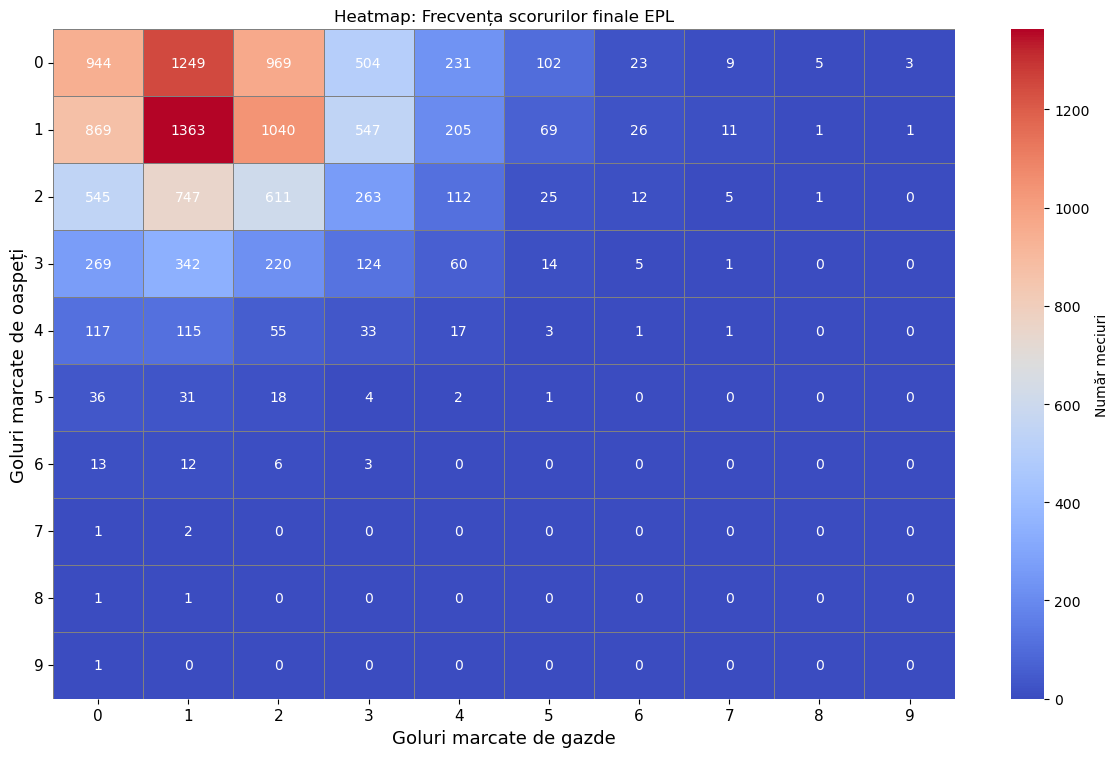

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(12, 8))

# Setăm ticks doar pentru scoruri care apar efectiv
x_labels = heatmap_data.columns.tolist()
y_labels = heatmap_data.index.tolist()

# Folosim o paletă mai blândă with some good palette for white text (no mako YlOrRd)
cmap = sns.color_palette("coolwarm", as_cmap=True)

ax = sns.heatmap(
    heatmap_data,
    annot=True,
    fmt="d",
    cmap=cmap,
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Număr meciuri'},
    annot_kws={"size": 10, "color": "white"},
    xticklabels=x_labels,
    yticklabels=y_labels
)

plt.title("Heatmap: Frecvența scorurilor finale EPL")
plt.xlabel("Goluri marcate de gazde", fontsize=13)
plt.ylabel("Goluri marcate de oaspeți", fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11, rotation=0)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Aici se poate observa o statistica destul de interesanta, si anume Top 10 echipe care au reusit sa castige meciuri care la pauza erau in dezavantaj (separat pentru deplasare si acasa).
Interesant cum Chelsea si Liverpool au reusit sa castige mai multe meciuri in deplasare din situatie de dezavantaj fata de cele jucate acasa.


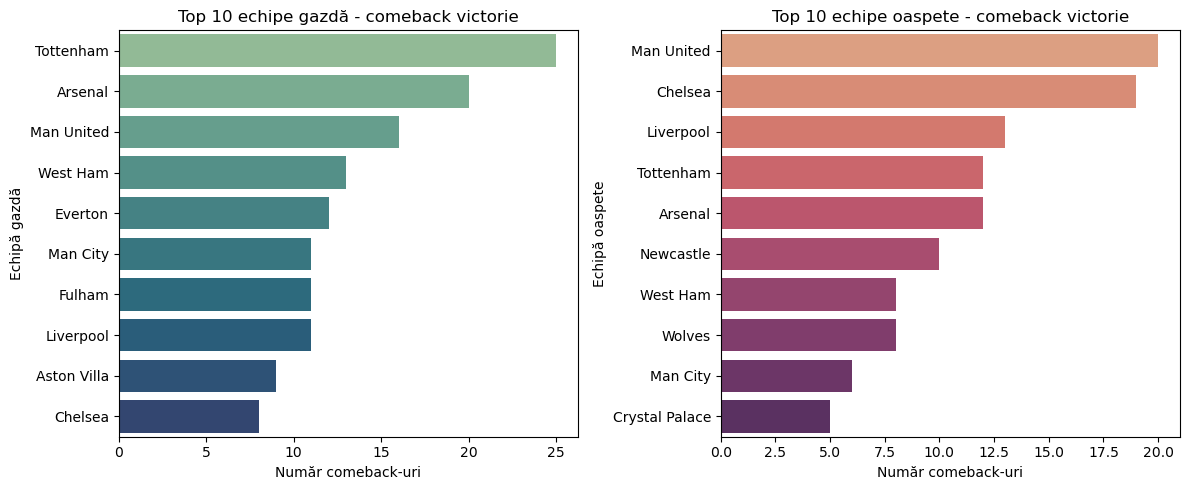

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convertim în Pandas pentru plotting
top10_home = home_win_comebacks.limit(10).toPandas()
top10_away = away_win_comebacks.limit(10).toPandas()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(data=top10_home, x="count", y="HomeTeam",
            palette="crest", hue="HomeTeam", legend=False)
plt.title("Top 10 echipe gazdă - comeback victorie")
plt.xlabel("Număr comeback-uri")
plt.ylabel("Echipă gazdă")

plt.subplot(1, 2, 2)
sns.barplot(data=top10_away, x="count", y="AwayTeam",
            palette="flare", hue="AwayTeam", legend=False)
plt.title("Top 10 echipe oaspete - comeback victorie")
plt.xlabel("Număr comeback-uri")
plt.ylabel("Echipă oaspete")

plt.tight_layout()
plt.show()

### V. Analiza Arbitrilor

Vom analiza arbitrii care au dat cele mai multe cartonase in EPL.


In [ ]:
# Înregistrăm df_detailed ca tabel SQL temporar
from pyspark.sql.functions import row_number
from pyspark.sql.window import Window
df_detailed.createOrReplaceTempView("matches")

arbitri_cartonase = spark.sql("""
    SELECT
        Referee,
        COUNT(*) AS Matches,
        SUM(HomeTeamYellowCards + AwayTeamYellowCards) AS TotalYellow,
        SUM(HomeTeamRedCards + AwayTeamRedCards) AS TotalRed,
        ROUND(AVG(HomeTeamYellowCards + AwayTeamYellowCards), 2) AS AvgYellowPerMatch,
        ROUND(AVG(HomeTeamRedCards + AwayTeamRedCards), 2) AS AvgRedPerMatch
    FROM matches
    GROUP BY Referee
    ORDER BY TotalYellow DESC
""")
arbitri_cartonase.show(20, truncate=False)

# Cartonașe galbene primite de fiecare echipă de la fiecare arbitru
fav_yellow = spark.sql("""
    SELECT
        Referee,
        HomeTeam AS Team,
        SUM(HomeTeamYellowCards) AS YellowCards
    FROM matches
    GROUP BY Referee, HomeTeam
    UNION ALL
    SELECT
        Referee,
        AwayTeam AS Team,
        SUM(AwayTeamYellowCards) AS YellowCards
    FROM matches
    GROUP BY Referee, AwayTeam
""")

# Pentru fiecare arbitru, echipa cu cele mai multe cartonașe galbene primite de la el

window = Window.partitionBy("Referee").orderBy(col("YellowCards").desc())
fav_yellow_ranked = fav_yellow.withColumn("Rank", row_number().over(window))
fav_yellow_max = fav_yellow_ranked.filter(
    col("Rank") == 1).select("Referee", "Team", "YellowCards")

fav_yellow_max.orderBy(col("YellowCards").desc()).show(20, truncate=False)

+-------------+-------+-----------+--------+-----------------+--------------+
|Referee      |Matches|TotalYellow|TotalRed|AvgYellowPerMatch|AvgRedPerMatch|
+-------------+-------+-----------+--------+-----------------+--------------+
|M Dean       |529    |1947       |108     |3.68             |0.2           |
|M Atkinson   |460    |1489       |67      |3.24             |0.15          |
|A Taylor     |391    |1369       |53      |3.5              |0.14          |
|M Oliver     |390    |1261       |52      |3.23             |0.13          |
|A Marriner   |392    |1226       |61      |3.13             |0.16          |
|P Dowd       |301    |1065       |65      |3.54             |0.22          |
|H Webb       |297    |982        |33      |3.31             |0.11          |
|M Clattenburg|293    |953        |47      |3.25             |0.16          |
|C Pawson     |259    |940        |37      |3.63             |0.14          |
|K Friend     |272    |920        |31      |3.38             |0.

#### 1. Bar chart: Top 10 arbitri după totalul cartonașelor galbene acordate


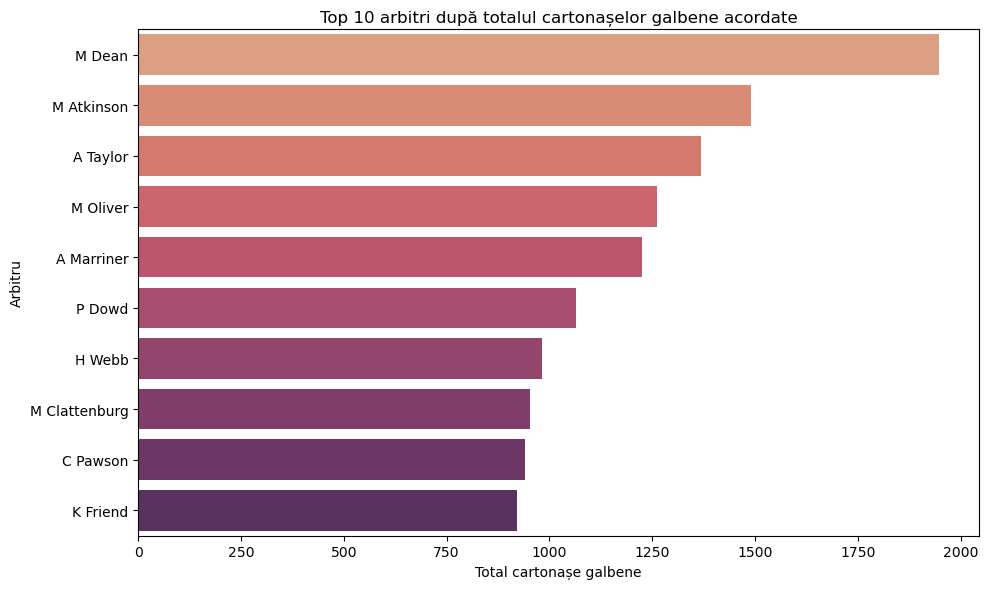

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convertim arbitri_cartonase în Pandas
arbitri_cartonase_pd = arbitri_cartonase.limit(10).toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=arbitri_cartonase_pd, x="TotalYellow",
            y="Referee", palette="flare", hue="Referee", dodge=False, legend=False)
plt.title("Top 10 arbitri după totalul cartonașelor galbene acordate")
plt.xlabel("Total cartonașe galbene")
plt.ylabel("Arbitru")
plt.tight_layout()
plt.show()

#### 2. Heatmap: Cartonașe galbene acordate de arbitri echipelor de top

Se poate observa spre exemplu cum Liverpool si Everton au primit cele mai putine cartonașe galbene din partea lui Mike Dean (probabil deoarece el este dintr-un oras din apropriere de Liverpool si asociatia de fotbal a decis sa nu-l trimita la meciuri celor 2 echipe).

In schimb, tot Mike Dean este cel mai sever arbitru din EPL.


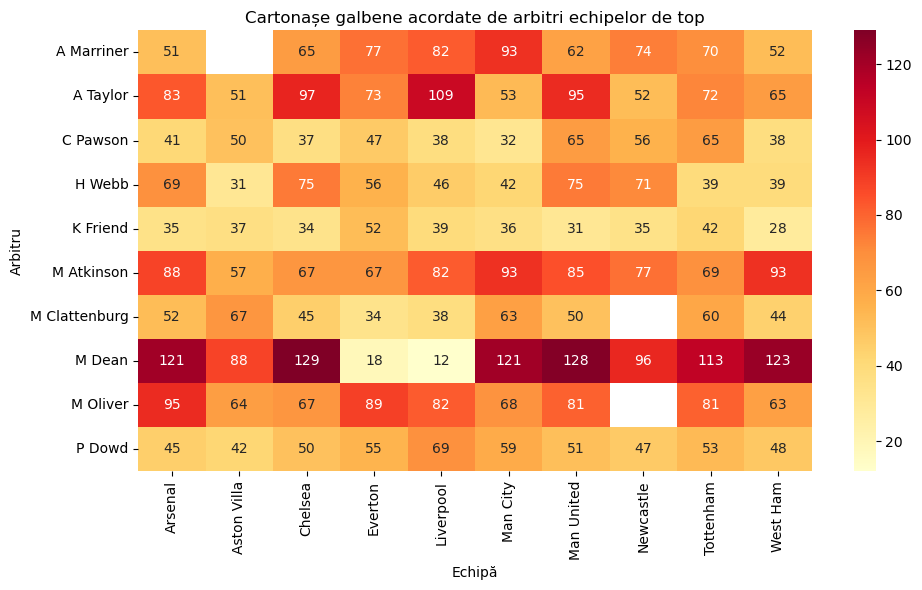

In [77]:
top_arbitri = [row["Referee"] for row in arbitri_cartonase.orderBy(
    col("TotalYellow").desc()).limit(10).collect()]
top_echipe = [row["Team"] for row in fav_yellow.groupBy("Team").sum(
    "YellowCards").orderBy(col("sum(YellowCards)").desc()).limit(10).collect()]

# Agregăm totalul cartonașelor galbene pentru fiecare pereche (arbitru, echipă)
fav_yellow_heatmap_agg = fav_yellow.groupBy("Referee", "Team").sum("YellowCards") \
    .withColumnRenamed("sum(YellowCards)", "TotalYellowCards") \
    .filter(col("Referee").isin(top_arbitri) & col("Team").isin(top_echipe)) \
    .toPandas()

# Pivot pentru heatmap
pivot = fav_yellow_heatmap_agg.pivot(
    index="Referee", columns="Team", values="TotalYellowCards")

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, cmap="YlOrRd", fmt=".0f")
plt.title("Cartonașe galbene acordate de arbitri echipelor de top")
plt.xlabel("Echipă")
plt.ylabel("Arbitru")
plt.tight_layout()
plt.show()